In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime
from zipfile import ZipFile
from urllib.request import urlretrieve

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

In [2]:
# To make the output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# Check use of GPU
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF, if GPU is available.")

Please install GPU version of TF, if GPU is available.


In [4]:
import sys, sklearn
print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'keras      {keras.__version__}')
print(f'numpy      {np.__version__}')


sklearn    0.24.2
tensorflow 2.8.0
keras      2.8.0
numpy      1.22.3


In [5]:
# Data access and prep
# Download and read into Pandas DataFrame
current_path = os.getcwd()
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-20m.zip", \
            current_path+"/datasets/movielens.zip")
ZipFile(current_path+"/datasets/movielens.zip", "r").extractall(current_path+"/datasets/")
ratingDF = pd.read_csv(current_path+"/datasets/ml-20m/ratings.csv")

In [6]:
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [7]:
# Convert fields into appropriate data types 
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = ratingDF.timestamp.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [8]:
# Store DataFrame as pickle for faster loading in the future
ratingDF.to_pickle(current_path+"/datasets/ml-20m/ratingPickle")
ratingDF = pd.read_pickle(current_path+"/datasets/ml-20m/ratingPickle")

In [9]:
# Preview data
ratingDF.head(10)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
5,1,112,3.5,2004-09-10 03:09:00
6,1,151,4.0,2004-09-10 03:08:54
7,1,223,4.0,2005-04-02 23:46:13
8,1,253,4.0,2005-04-02 23:35:40
9,1,260,4.0,2005-04-02 23:33:46


In [10]:
# Calculate summary statistics on full dataset
n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users

print(f'Number of unique users: {n_users}')
print(f'Number of unique movies: {n_movies}')
print(f'Number of total ratings: {n_ratings}')
print(f'Average number of ratings per user: {round(avg_ratings_per_user,1)}')

Number of unique users: 138493
Number of unique movies: 26744
Number of total ratings: 20000263
Average number of ratings per user: 144.4


In [11]:
n_users = ratingDF.userId.unique().shape[0]
print(f'Number of unique users: {n_users}')

Number of unique users: 138493


In [12]:
# Reduce size of dataset by taking top 1000 movies
movieIndex = ratingDF.groupby("movieId").count().sort_values(by="rating",ascending=False)[0:1000].index
ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

In [13]:
# Reduce size of dataset by sampling 1000 users
userIndex = ratingDFX2.groupby("userId").count().sort_values(by= 
    "rating",ascending=False).sample(n=1000, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

In [14]:
ratingDFX3.head()

,userId,movieId,rating,timestamp
4943,49,50,5.0,2013-05-03 02:50:26
4944,49,163,3.5,2013-05-03 02:43:37
4945,49,216,3.0,2013-05-03 02:45:58
4946,49,296,5.0,2013-05-03 02:50:13
4947,49,333,3.0,2013-05-03 02:44:38


In [15]:
# Reindex movie ID from 0 - 1000
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1
moviesDF.head()

,originalMovieId,newMovieId
0,50,1
1,163,2
2,216,3
3,296,4
4,333,5


In [16]:
# Reindex user ID
users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1
usersDF.head()

,originalUserId,newUserId
0,49,1
1,260,2
2,311,3
3,319,4
4,499,5


In [17]:
# Generate newly merged DataFrame
ratingDFX3 = ratingDFX3.merge(moviesDF,left_on='movieId',
                              right_on='originalMovieId')
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)
ratingDFX3 = ratingDFX3.merge(usersDF,left_on='userId', 
                              right_on='originalUserId')
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)
ratingDFX3.head()

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,49,50,5.0,2013-05-03 02:50:26,1,1
1,49,163,3.5,2013-05-03 02:43:37,2,1
2,49,216,3.0,2013-05-03 02:45:58,3,1
3,49,296,5.0,2013-05-03 02:50:13,4,1
4,49,333,3.0,2013-05-03 02:44:38,5,1


In [18]:
# Save as pickle new dataframe as pickle
pickle_file = os.path.sep.join(['', 'datasets', 'movielens_data', 'ratingReducedPickle'])
ratingDFX3.to_pickle(current_path + "/datasets/ml-20m/ratingReducedPickle")
ratingDFX3 = pd.read_pickle(current_path + "/datasets/ml-20m/ratingReducedPickle")

In [19]:
# Calculate summary statistics on reduced dataset
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

print(f'Number of unique users: {n_users}')
print(f'Number of unique movies: {n_movies}')
print(f'Number of total ratings: {n_ratings}')
print(f'Average number of ratings per user: {round(avg_ratings_per_user,1)}')

Number of unique users: 1000
Number of unique movies: 1000
Number of total ratings: 90213
Average number of ratings per user: 90.2


In [20]:
# Split into validation and test, such that each is 5% of the dataset
X_train, X_test = train_test_split(ratingDFX3, test_size=0.10, \
                                   shuffle=True, random_state=2018)
X_valid, X_test = train_test_split(X_test,     test_size=0.50, \
                                   shuffle=True, random_state=2018)

In [21]:
# Confirm size of train, validation, and test datasets
for (l,x) in [('train',X_train),('validation',X_valid),('test',X_test)]:
    print(f'Size of {l} set: {len(x)}')

Size of train set: 81191
Size of validation set: 4511
Size of test set: 4511


In [22]:
# Define cost function - Mean squared error
# Generate ratings matrix for train set
# Matrix of rows - customers, columns - movies, data - rating
# ratings_train = np.zeros((n_users, n_movies))
# ratings_valid = np.zeros((n_users, n_movies))
# ratings_test  = np.zeros((n_users, n_movies))
# for (X,ratings) in [(X_train,ratings_train),(X_valid,ratings_valid),(X_test,ratings_test)]:
#     for row in X.itertuples():
#         ratings[row[6]-1, row[5]-1] = row[3]

In [23]:
#Generate rating matrix for training set
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]

In [24]:
#Calculate spasity of the training ratings matrix
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print(f'Sparsity: {sparsity:.2f}')

Sparsity: 8.12


In [25]:
# Generate rating matrix for validation set
ratings_validation = np.zeros((n_users, n_movies))
for row in X_valid.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

In [26]:
# Generate rating matrix for test set
ratings_test  = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

In [27]:
# t = X_train.itertuples()
# print(list(t)[3])

# t = X_train.itertuples()
# c, *a = t
# print(c[1]-1)
# print(a[1]-1)


In [28]:
# Check the shape of our new matrix
ratings_train.shape, ratings_validation.shape, ratings_test.shape

((1000, 1000), (1000, 1000), (1000, 1000))

In [31]:
# Calculate the sparsity of the train, validation & test rating matrices
def calc_sparsity(label, ratings):
    sparsity = float(len(ratings.nonzero()[0]))
    sparsity /= (ratings.shape[0] * ratings.shape[1])
    sparsity *= 100
    print('{:s} Sparsity: {:4.2f}%'.format(label, sparsity))

In [33]:
for (lbl, rtg) in [('Train',ratings_train),('Validation',ratings_validation),('Test', ratings_test)]:
    calc_sparsity(lbl,rtg)

Train Sparsity: 8.12%
Validation Sparsity: 0.45%
Test Sparsity: 0.45%


In [37]:
# Define the cost function - here we will use mean squard error (MSE). Measure between predicted and actual values. We will create two vectors.
# One cevtor has the actual ratings and the other vector has the prediction
# First faltten the sparse matix with the validation set ratings, vector of actual ratings:
actual_valid = ratings_validation[ratings_validation.nonzero()].flatten()
actual_valid

array([3., 1., 3., ..., 3., 3., 4.])

In [40]:
# Test One - Calculate MSE by assigning an average rating for 3.5 for the validation set
pred_valid = np.zeros((len(X_valid),1))
pred_valid[pred_valid==0] = 3.5
pred_valid

array([[3.5],
       [3.5],
       [3.5],
       ...,
       [3.5],
       [3.5],
       [3.5]])

In [41]:
# The MSE of a complete guess is 1.06 here is the baseline to improve upon
naive_prediction = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using naive prediction: {round(naive_prediction,2)}')

Mean squared error using naive prediction: 1.06


In [43]:
# Test two - predict a users rating based on their average rating for all other movies. Lowering the MSE is an improvement
ratings_valid_pred = np.zeros((n_users, n_movies))
i = 0
for row in ratings_train:
    ratings_valid_pred[i][ratings_valid_pred[i]==0] = np.mean(row[row>0])
    i += 1

pred_valid = ratings_valid_pred[ratings_validation.nonzero()].flatten()
user_average = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using user average: {round(user_average,3)}')

Mean squared error using user average: 0.909


In [44]:
# Predict a users rating based on all other viewers rating of that movie
ratings_valid_pred = np.zeros((n_users, n_movies)).T
i = 0
for row in ratings_train.T:
    ratings_valid_pred[i][ratings_valid_pred[i]==0] = np.mean(row[row>0])
    i += 1

ratings_valid_pred = ratings_valid_pred.T
pred_valid = ratings_valid_pred[ratings_validation.nonzero()].flatten()
movie_average = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using movie average: {round(movie_average,3)}')

Mean squared error using movie average: 0.914


In [55]:
# Matrix Factorization - One latent factor. Learns representations for users and intems in a lower dimensional space and makes predications based on the newly learned representations.
n_latent_factors = 1

#Create one-dimenstional voctor of users for the user embedding
user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_factors, 
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

#Create one-dimensional vector of movies for movie embedding 
movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, 
                            output_dim=n_latent_factors,
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

# The output vector is the dot product of the user and movie vector. Adam optimizers will minimize the cost function - mean squared error
product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [56]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, epochs=100, 
                    validation_data=([X_valid.newUserId, X_valid.newMovieId], X_valid.rating), 
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 4s 1ms/step - loss: 13.9379 - val_loss: 12.6872
Epoch 2/100
2538/2538 [==============================] - 3s 1ms/step - loss: 10.0194 - val_loss: 7.3201
Epoch 3/100
2538/2538 [==============================] - 3s 1ms/step - loss: 5.2056 - val_loss: 3.6964
Epoch 4/100
2538/2538 [==============================] - 3s 1ms/step - loss: 2.7908 - val_loss: 2.2179
Epoch 5/100
2538/2538 [==============================] - 3s 1ms/step - loss: 1.7650 - val_loss: 1.5300
Epoch 6/100
2538/2538 [==============================] - 3s 1ms/step - loss: 1.2621 - val_loss: 1.1848
Epoch 7/100
2538/2538 [==============================] - 3s 1ms/step - loss: 1.0067 - val_loss: 1.0063
Epoch 8/100
2538/2538 [==============================] - 5s 2ms/step - loss: 0.8756 - val_loss: 0.9100
Epoch 9/100
2538/2538 [==============================] - 5s 2ms/step - loss: 0.8073 - val_loss: 0.8579
Epoch 10/100
2538/2538 [==============================] - 4s 2ms/step 

Minimum MSE: 0.794


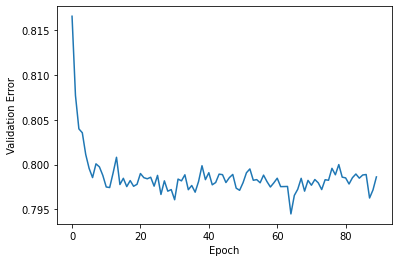

In [57]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print(f"Minimum MSE: {round(min(history.history['val_loss']),3)}")

In [58]:
#Matrix factorization using 3 latent factors
n_latent_factors = 3

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_factors, 
                           embeddings_regularizer=regularizers.l1(10e-7), 
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, 
                            output_dim=n_latent_factors, 
                            embeddings_regularizer=regularizers.l1(10e-7), 
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [59]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, epochs=100, 
                    validation_data=([X_valid.newUserId, X_valid.newMovieId], X_valid.rating), 
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 9s 1ms/step - loss: 11.8325 - val_loss: 7.2879
Epoch 2/100
2538/2538 [==============================] - 3s 1ms/step - loss: 4.1811 - val_loss: 2.4472
Epoch 3/100
2538/2538 [==============================] - 3s 1ms/step - loss: 1.7276 - val_loss: 1.3397
Epoch 4/100
2538/2538 [==============================] - 4s 1ms/step - loss: 1.0665 - val_loss: 0.9923
Epoch 5/100
2538/2538 [==============================] - 4s 1ms/step - loss: 0.8536 - val_loss: 0.8736
Epoch 6/100
2538/2538 [==============================] - 3s 1ms/step - loss: 0.7819 - val_loss: 0.8310
Epoch 7/100
2538/2538 [==============================] - 4s 2ms/step - loss: 0.7573 - val_loss: 0.8170
Epoch 8/100
2538/2538 [==============================] - 4s 1ms/step - loss: 0.7485 - val_loss: 0.8109
Epoch 9/100
2538/2538 [==============================] - 4s 2ms/step - loss: 0.7451 - val_loss: 0.8053
Epoch 10/100
2538/2538 [==============================] - 4s 2ms/step - 

Minimum MSE, 3 latent factors: 0.757


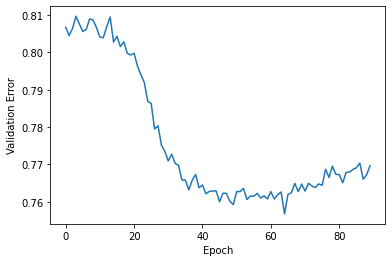

In [61]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print(f"Minimum MSE, 3 latent factors: {round(min(history.history['val_loss']),3)}")

In [62]:
#5 Latent Factors
n_latent_factors = 5

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_factors, 
                           embeddings_regularizer=regularizers.l1(1e-6), 
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, 
                            output_dim=n_latent_factors, 
                            embeddings_regularizer=regularizers.l1(1e-6), 
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [63]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, epochs=100, 
                    validation_data=([X_valid.newUserId,X_valid.newMovieId], X_valid.rating), 
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 3s 1ms/step - loss: 11.1673 - val_loss: 5.4418
Epoch 2/100
2538/2538 [==============================] - 3s 1ms/step - loss: 2.9210 - val_loss: 1.7109
Epoch 3/100
2538/2538 [==============================] - 3s 1ms/step - loss: 1.2356 - val_loss: 1.0404
Epoch 4/100
2538/2538 [==============================] - 3s 1ms/step - loss: 0.8737 - val_loss: 0.8744
Epoch 5/100
2538/2538 [==============================] - 3s 1ms/step - loss: 0.7830 - val_loss: 0.8299
Epoch 6/100
2538/2538 [==============================] - 4s 1ms/step - loss: 0.7588 - val_loss: 0.8168
Epoch 7/100
2538/2538 [==============================] - 4s 1ms/step - loss: 0.7522 - val_loss: 0.8137
Epoch 8/100
2538/2538 [==============================] - 4s 1ms/step - loss: 0.7500 - val_loss: 0.8114
Epoch 9/100
2538/2538 [==============================] - 4s 1ms/step - loss: 0.7488 - val_loss: 0.8059
Epoch 10/100
2538/2538 [==============================] - 3s 1ms/step - 

Minimum MSE: 0.771


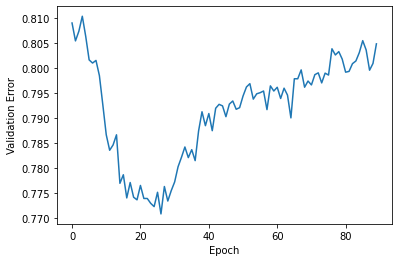

In [64]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print(f"Minimum MSE: {round(min(history.history['val_loss']),3)}")

#Minimum MSE Fails to improve with increaseing latent factors

In [68]:
# Make code compatible with v1 of TF
tf.compat.v1.disable_eager_execution()

In [65]:
# Reccomender system using RBM (Restricted Boltzman Machines)

class RBM(object):
    
    def __init__(self, input_size, output_size,learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32) #Weight Matrix
        self.hb = np.zeros([output_size], dtype=np.float32) #Hidden bias factors
        self.vb = np.zeros([input_size], dtype=np.float32) #visible bias factors

    def prob_h_given_v(self, visible, w, hb): # function for the forward pass of data. H is hidden layer, V is visible
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb): #function defining the backward pass
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs): #Sampling function
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.compat.v1.placeholder(tf.float32, [self._input_size, self._output_size]) #weights placeholder
        _hb = tf.compat.v1.placeholder(tf.float32, [self._output_size]) #Hidden bias placeholder
        _vb = tf.compat.v1.placeholder(tf.float32, [self._input_size]) #visible bias placeholder
        
        #Set to store previous values
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32) 
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)

        #Set to store current values
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        #Placeholdere for visible layer. Hidden layer is matix multiplication of the visible layer and the weights matrix and matrix addition of the hidden bias 
        v0 = tf.compat.v1.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))

        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.cast(tf.shape(v0)[0], tf.float32)
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

In [66]:
#Begin training 
# Convert inputX into float32
inputX = ratings_train
inputX = inputX.astype(np.float32)

# Define the parameters of the RBMs we will train
rbm=RBM(1000,1000,1,1000,200)

In [69]:
# Train RBM model|
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

Epoch: 0 reconstruction error: 1.105469
Epoch: 1 reconstruction error: 1.080263
Epoch: 2 reconstruction error: 1.088436
Epoch: 3 reconstruction error: 1.089600
Epoch: 4 reconstruction error: 1.098711
Epoch: 5 reconstruction error: 1.099586
Epoch: 6 reconstruction error: 1.091105
Epoch: 7 reconstruction error: 1.084481
Epoch: 8 reconstruction error: 1.090436
Epoch: 9 reconstruction error: 1.082577
Epoch: 10 reconstruction error: 1.085554
Epoch: 11 reconstruction error: 1.092507
Epoch: 12 reconstruction error: 1.085089
Epoch: 13 reconstruction error: 1.092800
Epoch: 14 reconstruction error: 1.088084
Epoch: 15 reconstruction error: 1.094339
Epoch: 16 reconstruction error: 1.087638
Epoch: 17 reconstruction error: 1.094136
Epoch: 18 reconstruction error: 1.091401
Epoch: 19 reconstruction error: 1.092515
Epoch: 20 reconstruction error: 1.088456
Epoch: 21 reconstruction error: 1.098387
Epoch: 22 reconstruction error: 1.092145
Epoch: 23 reconstruction error: 1.100692
Epoch: 24 reconstruction e

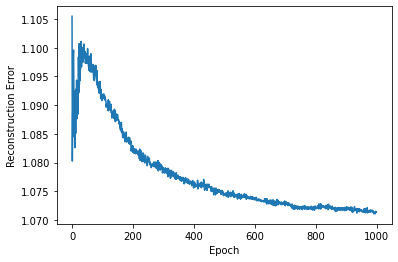

In [70]:
# Plot reconstruction errors
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error");

In [72]:
# Predict ratings for validation set
inputValid = ratings_validation
inputValid = inputValid.astype(np.float32)

_, reconstructedOutput_valid, _ = rbm.rbm_output(inputValid)

In [75]:
# Calculate MSE on validation set
predictionsArray = reconstructedOutput_valid
pred_valid = predictionsArray[ratings_validation.nonzero()].flatten()
actual_valid = ratings_validation[ratings_validation.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using RBM prediction: {round(rbm_prediction,2)}')

Mean squared error using RBM prediction: 9.34
